In [21]:
! pip install numpy scipy matplotlib 


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [22]:
import sys
import os
import utils
import math
import numpy as np
from scipy.stats import multinomial
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

import scipy.io as sio


#from multinomial import Multinomial, Categorical, DistributionExpectation

import warnings
warnings.filterwarnings("ignore")

In [23]:
rseed = 5
np.random.seed(rseed)

In [ ]:

from scipy.stats import multinomial
import scipy.io as sio
import numpy as np
import math


def Multinomial(A, B, alpha=0):
    """Fit multinomial over words with optional Dirichlet smoothing. Returns (pi, results dict)."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])

    # ML estimate with Dirichlet pseudocounts
    pi = np.array([np.sum(A[:, 2][A[:, 1] == w]) for w in range(1, W + 1)])
    pi = pi + alpha
    cc = np.copy(pi)
    pi = pi / np.sum(pi)

    unique_docs = np.unique(B[:, 0])
    res = {'cc': cc}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = multinomial.logpmf(ow, n=nd, p=pi)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return pi, res


def Categorical(A, B, pi):
    """Log-prob under categorical (avoids multinomial coefficient). Handles zero-prob words."""
    logpi = np.log(pi)

    def logpmf(ow, n, lp, pi):
        assert sum(ow) == n
        mask = pi <= 0.0
        if np.sum(ow[mask]) > 0:
            return -np.inf
        return np.sum(np.where(mask, 0, ow * lp))

    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    unique_docs = np.unique(B[:, 0])
    res = {}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = logpmf(ow, n=nd, lp=logpi, pi=pi)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return res


def LogBetaFunction(c):
    """Log of multivariate Beta function: log B(c) = sum log Gamma(c_i) - log Gamma(sum c_i)."""
    return sum(math.lgamma(q) for q in c) - math.lgamma(sum(c))


def LogDocumentProbability(c, c0):
    """Log predictive probability of doc counts c under Dirichlet posterior with pseudocounts c0."""
    return LogBetaFunction(c + c0) - LogBetaFunction(c0)


def DistributionExpectation(A, B, c0):
    """Per-document log-prob and perplexity using Dirichlet-multinomial (integrating out pi)."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    unique_docs = np.unique(B[:, 0])
    res = {}

    for doc in unique_docs:
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1].flatten(), B[idx, 2].flatten()
        nd = np.sum(c)

        ow = np.zeros(W, dtype=int)
        for iw, ic in zip(w, c):
            ow[iw - 1] += ic

        lp = LogDocumentProbability(ow, c0)
        res[doc] = (nd, lp, np.exp(-lp / nd))

    return res


BMM

In [ ]:
import scipy.io as sio
import numpy as np


def BMM(A, B, K, alpha, gamma):
    """Gibbs sampler for mixture of multinomials with Dirichlet priors."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    D = np.max(A[:, 0])

    # random init: assign docs to components
    sd = np.floor(K * np.random.rand(D)).astype(int)
    swk = np.zeros((W, K))       # word counts per component
    sk_docs = np.zeros((K, 1), dtype=int)  # doc counts per component

    for d in range(D):
        idx = np.where(A[:, 0] == d + 1)
        w, c = np.array(A[idx, 1]), np.array(A[idx, 2])
        k = sd[d]
        swk[w-1, k] += c
        sk_docs[k] += 1

    sk_docs_tracker = [np.copy(sk_docs)]
    sk_words = np.sum(swk, axis=0)

    num_iters_gibbs = 50
    for iter in range(num_iters_gibbs):
        for d in range(D):
            idx = np.where(A[:, 0] == d + 1)
            w, c = A[idx, 1], A[idx, 2]
            old_class = sd[d]

            # remove doc d from counts
            swk[w-1, old_class] -= c
            sk_docs[old_class] -= 1
            sk_words[old_class] -= np.sum(c)

            # conditional log-prob for each component
            lb = np.zeros(K)
            for k in range(K):
                ll = np.dot(np.log(swk[w-1, k] + gamma) - np.log(sk_words[k] + gamma * W), c.T)
                lb[k] = np.log(sk_docs[k] + alpha) + ll

            b = np.exp(lb - np.max(lb))
            kk = sampleDiscrete(b, np.random.rand())

            # add doc d back under new assignment
            swk[w-1, kk] += c
            sk_docs[kk] += 1
            sk_words[kk] += np.sum(c)
            sd[d] = kk

        sk_docs_tracker.append(np.copy(sk_docs))

    # test perplexity (log-sum-exp over components)
    lp, nd = 0, 0
    for doc in np.unique(B[:, 0]):
        idx = np.where(B[:, 0] == doc)
        w, c = B[idx, 1], B[idx, 2]
        z = np.log(sk_docs + alpha) - np.log(np.sum(sk_docs + alpha))
        for k in range(K):
            b = (swk[:, k] + gamma) / (sk_words[k] + gamma * W)
            z[k] += np.dot(c, np.log(b[w-1]).T)[0]
        lp += np.log(np.sum(np.exp(z - np.max(z)))) + np.max(z)
        nd += np.sum(c)

    perplexity = np.exp(-lp / nd)
    return perplexity, swk, sk_docs_tracker

LDA

In [ ]:
import scipy.io as sio
import numpy as np
from scipy.sparse import coo_matrix as sparse


def LDA(A, B, K, alpha, gamma):
    """Collapsed Gibbs sampler for LDA. Returns perplexity, word-topic counts, trackers."""
    W = np.max([np.max(A[:, 1]), np.max(B[:, 1])])
    D = np.max(A[:, 0])

    swd = sparse((A[:, 2], (A[:, 1]-1, A[:, 0]-1))).tocsr()
    Swd = sparse((B[:, 2], (B[:, 1]-1, B[:, 0]-1))).tocsr()

    # init: random topic assignments per word occurrence
    skd = np.zeros((K, D))
    swk = np.zeros((W, K))
    s = []
    for d in range(D):
        z = np.zeros((W, K))
        words_in_doc_d = A[np.where(A[:, 0] == d+1), 1][0] - 1
        for w in words_in_doc_d:
            c = swd[w, d]
            for i in range(c):
                k = int(np.floor(K * np.random.rand()))
                z[w, k] += 1
        skd[:, d] = np.sum(z, axis=0)
        swk += z
        s.append(sparse(z))

    sk = np.sum(skd, axis=1)
    skd_tracker = [np.copy(skd)]
    swk_tracker = [np.copy(swk)]

    # Gibbs sweeps over training corpus
    num_gibbs_iters = 50
    for iter in range(num_gibbs_iters):
        print(f"Train sweep {iter+1}/{num_gibbs_iters}", end="\r")
        for d in range(D):
            z = s[d].todense()
            words_in_doc_d = A[np.where(A[:, 0] == d+1), 1][0] - 1
            for w in words_in_doc_d:
                a = z[w, :].copy()
                indices = np.where(a > 0)[1]
                np.random.shuffle(indices)
                for k in indices:
                    k = int(k)
                    for i in range(int(a[0, k])):
                        z[w, k] -= 1
                        swk[w, k] -= 1
                        sk[k] -= 1
                        skd[k, d] -= 1
                        b = (alpha + skd[:, d]) * (gamma + swk[w, :]) / (W*gamma + sk)
                        kk = sampleDiscrete(b, np.random.rand())
                        z[w, kk] += 1
                        swk[w, kk] += 1
                        sk[kk] += 1
                        skd[kk, d] += 1
            s[d] = sparse(z)
        skd_tracker.append(np.copy(skd))
        swk_tracker.append(np.copy(swk))
    print()

    # test perplexity: Gibbs sampling for held-out docs with fixed swk, sk
    lp, nd = 0, 0
    unique_docs_in_b = np.unique(B[:, 0])
    for qq, d in enumerate(unique_docs_in_b, 1):
        print(f"Test doc {qq}/{len(unique_docs_in_b)}", end="\r")
        z = np.zeros((W, K))
        words_in_d = B[np.where(B[:, 0] == d), 1][0] - 1
        for w in words_in_d:
            c = Swd[w, d-1]
            for i in range(c):
                z[w, int(np.floor(K * np.random.rand()))] += 1

        Skd = np.sum(z, axis=0)
        for iters in range(50):  # burn-in on test doc
            for w in words_in_d:
                a = z[w, :].copy()
                indices = np.where(a > 0)[0]
                np.random.shuffle(indices)
                for k in indices:
                    k = int(k)
                    for i in range(int(a[k])):
                        z[w, k] -= 1
                        Skd[k] -= 1
                        b = (alpha + Skd) * (gamma + swk[w, :]) / (W*gamma + sk)
                        kk = sampleDiscrete(b, np.random.rand())
                        z[w, kk] += 1
                        Skd[kk] += 1

        # predictive: p(w) = sum_k theta_k * phi_kw
        b1 = ((alpha + Skd) / np.sum(alpha + Skd))[:, None]
        b2 = (gamma + swk) / (W*gamma + sk)
        b = np.matmul(b2, b1)
        wc = B[np.where(B[:, 0] == d), 1:][0]
        lp += np.dot(np.log(b[wc[:, 0]-1]).T, wc[:, 1])
        nd += np.sum(wc[:, 1])

    perplexity = np.exp(-lp / nd)
    return perplexity, swk, skd_tracker, swk_tracker

Task

In [ ]:
from utils import *
# Load text data
A, B, V = load_ml("kos_doc_data.mat")

# no. of clusters
K = 20

#params of dirichlet over mixture comps.
alpha = 10

# params of dirichlet over words
gamma = .1 

perplexity, swk, sk_docs_tracker = BMM(A, B, K, alpha, gamma)

In [ ]:
print("Perplexity of the Bayesian Mixture Model", perplexity)

I = 5
indices = np.argsort(-swk, axis =0)
indices = indices[:20, :]

top_words = V[indices]

# printing top words
for topw in top_words[:, :, 0]:
    print()
    for word in topw[:I]:
        print(word[0], end = (20 - len(word[0])) * " ")

Perplexity of the Bayesian Mixture Model 2101.4790916638776

senate              november            film                dean                general             
race                poll                media               kerry               fallujah            
house               bush                bush                edwards             november            
republican          house               fahrenheit          primary             saleh               
elections           senate              moore               clark               iraq                
democratic          republicans         moores              poll                war                 
state               kerry               limbaugh            democratic          military            
district            polls               debunking           gephardt            iraqi               
democrats           governor            michael             iowa                petraeus            
seat                electoral 

In [ ]:
# mixt props
pis = np.zeros((len(sk_docs_tracker), K))
for i in range(pis.shape[0]):
    # doc count + prior
    pis[i] = sk_docs_tracker[i].flatten() + alpha

# normaise
pis = pis/np.sum(pis, axis = 1, keepdims = True)
# mosr likely topic
tp = np.argmax(pis[-1])
for topic in top_words[:, tp, 0]:
    for word in topic:
        print(word, end = " ")

bush kerry campaign democratic party president general republicans republican people democrats dean state time media john political election states news 

```
    Saving the most likely topics here:
    
    seed 1: 2092.268119165107
            bush iraq war administration president people kerry time american general house news bushs 
            military white government iraqi years political states

    seed 3: 2123.59626206069
            bush democratic kerry campaign party senate democrats house republican race state republicans 
            elections percent election general gop time poll candidates 
            
    seed 5: 2151.655670450547
            bush kerry campaign democratic party

    seed 10: 2151.655670450547
            bush iraq war administration president 
        
```

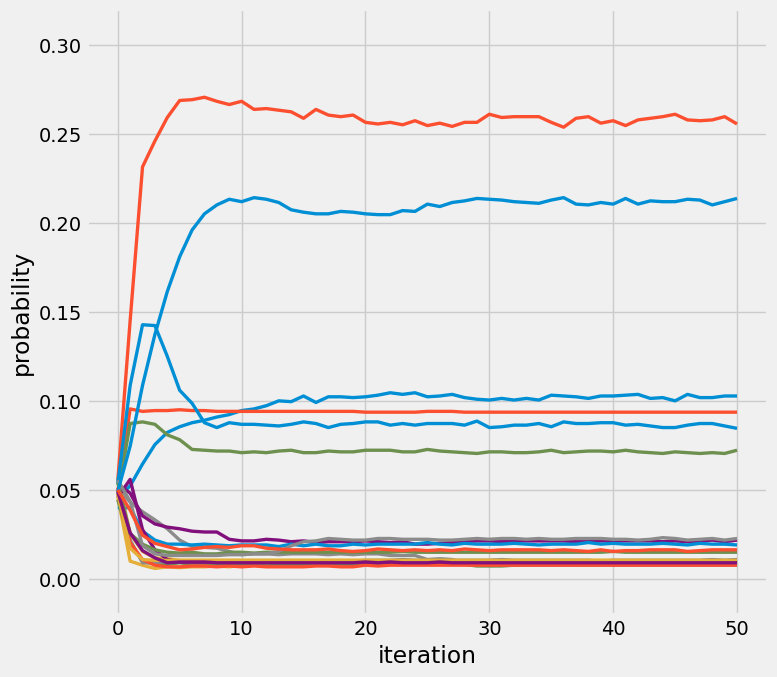

In [ ]:
# zipf's law
plt.figure(figsize = (8, 7))
plt.plot(pis, linewidth=2.4)
plt.ylabel('probability')
plt.xlabel('iteration')
plt.ylim(-0.02, 0.32)

plt.tight_layout()
plt.show()